In [2]:
%load_ext autoreload
%autoreload 2

import sys
import tskit
import tsdate

import numpy as np
import msprime
import torch
import pyro
from pyro import poutine

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import pyslim

from fit import fit_guide
import models
from models import NaiveModel, ConditionedTimesNaiveModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 1: A tree sequence produced by msprime (no locations)

In [11]:
msprime_ts = tskit.load("coalescent_sim.trees")
# This tree sequence can be reproduced with the following code:
# ts = msprime.simulate(500, Ne=2000, mutation_rate=1e-8, recombination_rate=1e-8, random_seed=1)

In [12]:
msprime_ts

In [26]:
# We can estimate the times of the tree sequence (without location)
# Specify the correct Ne and mutation rate
pyro_time_marginal, _, _, unbound_guide, losses_marginal, final_elbo = fit_guide(
    msprime_ts, leaf_location=None, Ne=2000, mutation_rate=1e-8, steps=10000, log_every=1000)

step 0 loss = 17.007, Migration scale = None, time conv. diagnostic = 0.00499, iter. per sec. = 0.00
step 1000 loss = 1.8203, Migration scale = None, time conv. diagnostic = 0.48, iter. per sec. = 183.82
step 2000 loss = 1.687, Migration scale = None, time conv. diagnostic = 0.107, iter. per sec. = 146.30
step 3000 loss = 1.7052, Migration scale = None, time conv. diagnostic = 0.0434, iter. per sec. = 193.40
step 4000 loss = 1.654, Migration scale = None, time conv. diagnostic = 0.0314, iter. per sec. = 203.09
step 5000 loss = 1.6371, Migration scale = None, time conv. diagnostic = 0.0256, iter. per sec. = 203.12
step 6000 loss = 1.6391, Migration scale = None, time conv. diagnostic = 0.0209, iter. per sec. = 195.93
step 7000 loss = 1.6526, Migration scale = None, time conv. diagnostic = 0.0169, iter. per sec. = 199.92
step 8000 loss = 1.6269, Migration scale = None, time conv. diagnostic = 0.015, iter. per sec. = 204.76
step 9000 loss = 1.6405, Migration scale = None, time conv. diagn

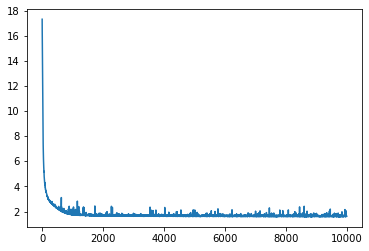

In [27]:
plt.plot(losses_marginal)

In [25]:
# We can estimate the times of the tree sequence (without location)
# Specify the correct Ne and mutation rate
pyro_time_init_true, _, _, unbound_guide_init_true, losses_init_true, final_elbo_init_true = fit_guide(
    msprime_ts, leaf_location=None, mutation_rate=1e-8, steps=10000, log_every=1000, Ne=2000,
    init_times=torch.tensor(msprime_ts.tables.nodes.time[msprime_ts.num_samples:], dtype=torch.float))

step 0 loss = 3.7925, Migration scale = None, time conv. diagnostic = 0.00499, iter. per sec. = 0.00
step 1000 loss = 1.8056, Migration scale = None, time conv. diagnostic = 0.539, iter. per sec. = 132.47
step 2000 loss = 1.6591, Migration scale = None, time conv. diagnostic = 0.101, iter. per sec. = 181.59
step 3000 loss = 1.6562, Migration scale = None, time conv. diagnostic = 0.0405, iter. per sec. = 189.92
step 4000 loss = 1.6679, Migration scale = None, time conv. diagnostic = 0.0306, iter. per sec. = 194.87
step 5000 loss = 1.6321, Migration scale = None, time conv. diagnostic = 0.0252, iter. per sec. = 209.81
step 6000 loss = 1.6409, Migration scale = None, time conv. diagnostic = 0.02, iter. per sec. = 210.69
step 7000 loss = 1.6405, Migration scale = None, time conv. diagnostic = 0.0166, iter. per sec. = 203.45
step 8000 loss = 1.6241, Migration scale = None, time conv. diagnostic = 0.0151, iter. per sec. = 204.01
step 9000 loss = 1.6287, Migration scale = None, time conv. dia

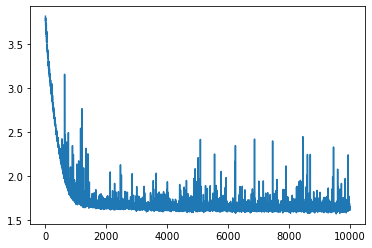

In [28]:
plt.plot(losses_init_true)

In [20]:
dated = tsdate.date(msprime_ts, mutation_rate=1e-8, Ne=2000)

MSLE of tspyro is 0.3237957650681435
MSLE of tspyro_init_true is 0.3165167814479527
MSLE of tsdate is 0.2582001571511334


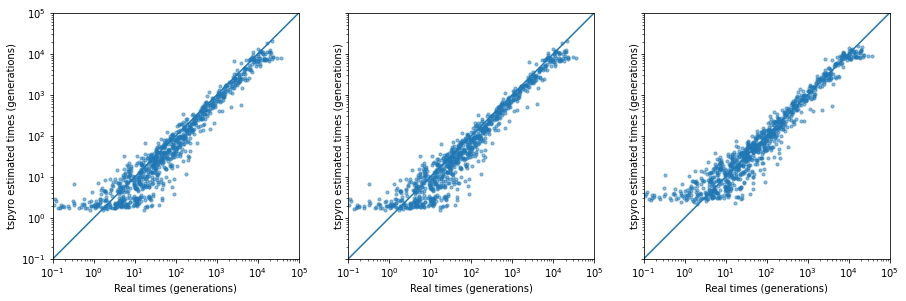

In [29]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,10))

estimated_times = [pyro_time_marginal, pyro_time_init_true, dated.tables.nodes.time]
estimation_names = ["tspyro", "tspyro_init_true", "tsdate"]
for ax, name, times in zip(axes, estimation_names, estimated_times):
    ax.set_aspect('equal')
    ax.scatter(msprime_ts.tables.nodes.time, times, s=10, alpha=0.5)
    ax.set_xlim(0.1, 100000)
    ax.set_ylim(0.1, 100000)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(ax.get_xlim(), ax.get_ylim())
    ax.set_xlabel("Real times (generations)")
    ax.set_ylabel("tspyro estimated times (generations)")
    print("MSLE of {} is {}".format(name, mean_squared_log_error(msprime_ts.tables.nodes.time, times)))

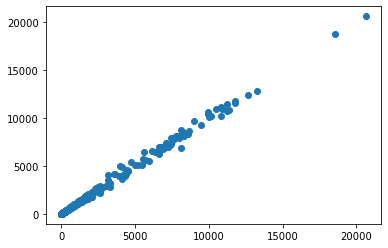

In [32]:
plt.scatter(pyro_time_marginal, pyro_time_init_true)

# Example 2: SLiM tree sequence

In [33]:
ts = tskit.load("slim_2d_continuous_recapitated_mutated.trees")


In [34]:
# Now let's randomly sample 200 leaf nodes
rng = np.random.default_rng(20)
random_sample = np.random.choice(np.arange(0, ts.num_samples), 200, replace=False)
sampled_ts = ts.simplify(samples=random_sample)

In [35]:
sampled_ts

In [36]:
# Next, we need to get the locations of the nodes
node_locations = np.full((sampled_ts.num_nodes, 2), -1, dtype=float)
no_location_nodes = []
for node in sampled_ts.nodes():
    if node.individual != -1:
        node_locations[node.id, :] = sampled_ts.individual(node.individual).location[:2]
    else:
        no_location_nodes.append(node.id)
# We want a tensor with only the leaf nodes for inference
leaf_locations = torch.tensor(node_locations[sampled_ts.samples()])



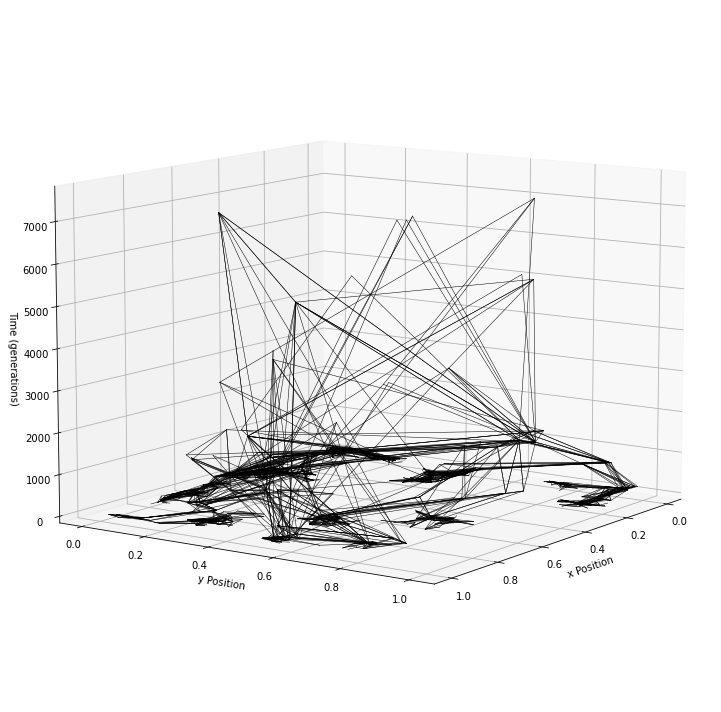

In [37]:
# Let's visualize the tree sequence in three dimensions
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
times = sampled_ts.tables.nodes.time
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = node_locations[edge.child]
        parent_loc = node_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="black", linewidth=0.5)

ax.set_xlabel("x Position")
ax.set_ylabel("y Position")
ax.set_zlabel("Time (generations)")
ax.view_init(10, 35)
plt.tight_layout()

In [40]:
# Marginal inference of time
slim_pyro_time_marginal, _, _, slim_unbound_guide_marginal, slim_losses_marginal, _ = fit_guide(
    sampled_ts, leaf_location=None,
    migration_likelihood=None,
    Ne=1000, mutation_rate=1e-8, steps=10000, log_every=1000)



step 0 loss = 10.419, Migration scale = None, time conv. diagnostic = 0.00499, iter. per sec. = 0.00
step 1000 loss = 3.6473, Migration scale = None, time conv. diagnostic = 0.569, iter. per sec. = 143.74
step 2000 loss = 3.4965, Migration scale = None, time conv. diagnostic = 0.114, iter. per sec. = 152.12
step 3000 loss = 3.4766, Migration scale = None, time conv. diagnostic = 0.0478, iter. per sec. = 149.24
step 4000 loss = 3.4429, Migration scale = None, time conv. diagnostic = 0.0304, iter. per sec. = 104.81
step 5000 loss = 3.451, Migration scale = None, time conv. diagnostic = 0.0238, iter. per sec. = 138.29
step 6000 loss = 3.4488, Migration scale = None, time conv. diagnostic = 0.0188, iter. per sec. = 154.98
step 7000 loss = 3.4616, Migration scale = None, time conv. diagnostic = 0.0152, iter. per sec. = 153.79
step 8000 loss = 3.4442, Migration scale = None, time conv. diagnostic = 0.0142, iter. per sec. = 144.91
step 9000 loss = 3.4582, Migration scale = None, time conv. di

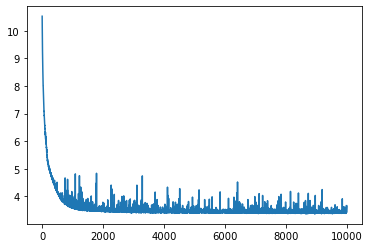

In [41]:
plt.plot(slim_losses_marginal)

In [42]:
# Let's perform joint inference of time and location

# We restrict inference of locations to nodes within 100 generations of the samples (which are all at time zero)
masked = sampled_ts.tables.nodes.time >= 100
mask = torch.ones(sampled_ts.num_edges, dtype=torch.bool)
for e, edge in enumerate(sampled_ts.edges()):
    if masked[edge.child]:
        mask[e] = False
migration_likelihood = tspyro.models.euclidean_migration
migration_likelihood = poutine.mask(
    migration_likelihood, mask=mask)

slim_inferred_times_joint, slim_inferred_locations, slim_migration_scale_joint, slim_guide_joint, slim_losses_joint, _ = fit_guide(
    sampled_ts, leaf_location=leaf_locations,
    migration_likelihood=migration_likelihood,
    Ne=1000, mutation_rate=1e-8, steps=10000, log_every=1000)



step 0 loss = 26.505, Migration scale = 0.9950136542320251, time conv. diagnostic = 0.005, iter. per sec. = 0.00
step 1000 loss = 1.7506, Migration scale = 0.02591129206120968, time conv. diagnostic = 0.628, iter. per sec. = 67.22
step 2000 loss = -1.0143, Migration scale = 0.009628178551793098, time conv. diagnostic = 0.174, iter. per sec. = 59.58
step 3000 loss = -1.517, Migration scale = 0.007909270003437996, time conv. diagnostic = 0.0833, iter. per sec. = 49.99
step 4000 loss = -1.7079, Migration scale = 0.0074587431736290455, time conv. diagnostic = 0.0506, iter. per sec. = 63.93
step 5000 loss = -1.805, Migration scale = 0.007219085935503244, time conv. diagnostic = 0.0348, iter. per sec. = 48.51
step 6000 loss = -1.8949, Migration scale = 0.007110998500138521, time conv. diagnostic = 0.0265, iter. per sec. = 58.32
step 7000 loss = -1.937, Migration scale = 0.00704911258071661, time conv. diagnostic = 0.0198, iter. per sec. = 65.22
step 8000 loss = -2.0002, Migration scale = 0.0

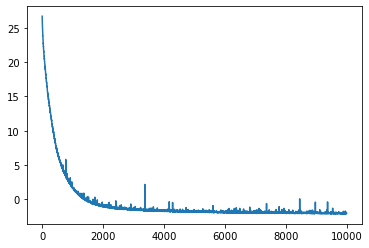

In [43]:
plt.plot(slim_losses_joint)

In [59]:
# Let's perform joint inference of time and location: initalize to true locations

# We restrict inference of locations to nodes within 100 generations of the samples (which are all at time zero)
masked = sampled_ts.tables.nodes.time >= 100
mask = torch.ones(sampled_ts.num_edges, dtype=torch.bool)
for e, edge in enumerate(sampled_ts.edges()):
    if masked[edge.child]:
        mask[e] = False
migration_likelihood = models.euclidean_migration
# migration_likelihood = poutine.mask(
#     migration_likelihood, mask=mask)

slim_inferred_times_joint, slim_inferred_locations, slim_migration_scale_joint, slim_guide_joint, slim_losses_joint, _ = fit_guide(
    sampled_ts, leaf_location=leaf_locations,
    migration_likelihood=migration_likelihood,
    init_loc=node_locations, Model=models.NaiveModel,
    Ne=1000, mutation_rate=1e-8, steps=10000, log_every=1000)




TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray

In [52]:
leaf_locations

tensor([[0.1988, 0.4329],
        [0.1882, 0.9839],
        [0.0556, 0.3497],
        [0.6402, 0.7217],
        [0.0217, 0.7447],
        [0.9797, 0.5463],
        [0.7595, 0.5208],
        [0.9617, 0.5346],
        [0.2467, 0.0404],
        [0.0381, 0.1221],
        [0.6684, 0.7255],
        [0.5835, 0.0046],
        [0.0081, 0.7639],
        [0.7562, 0.3363],
        [0.1864, 0.4474],
        [0.7483, 0.4360],
        [0.8272, 0.0267],
        [0.6444, 0.6584],
        [0.9198, 0.3475],
        [0.7959, 0.0542],
        [0.9803, 0.5028],
        [0.5827, 0.0287],
        [0.6647, 0.7685],
        [0.6647, 0.7685],
        [0.0045, 0.1674],
        [0.0078, 0.1649],
        [0.6732, 0.5676],
        [0.2299, 0.8887],
        [0.6755, 0.0493],
        [0.0196, 0.2124],
        [0.3196, 0.1378],
        [0.0274, 0.0061],
        [0.1515, 0.9437],
        [0.1920, 0.9211],
        [0.1449, 0.9820],
        [0.7789, 0.3525],
        [0.0160, 0.7202],
        [0.3729, 0.1910],
        [0.5

In [ ]:
dated_slim = tsdate.date(sampled_ts, mutation_rate=1e-8, Ne=1000)


MSLE of tspyro_marginal is 0.21817737774536194
MSLE of tspyro_joint is 0.38151360064164214
MSLE of tsdate is 0.20083636602613436


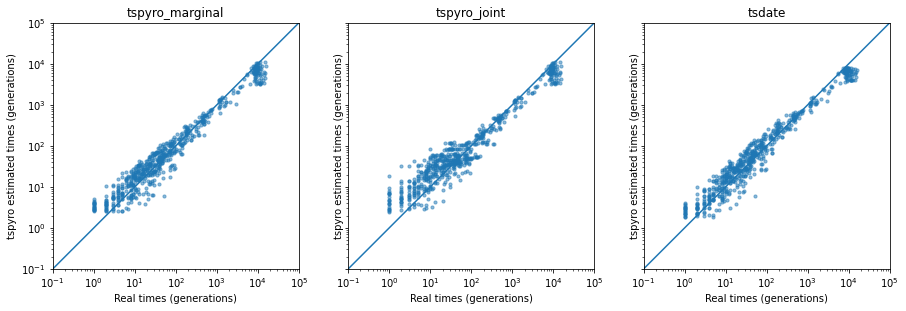

In [64]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,10))

estimated_times = [slim_inferred_times_marginal, slim_inferred_times_joint, dated_slim.tables.nodes.time]
estimation_names = ["tspyro_marginal", "tspyro_joint", "tsdate"]
for ax, name, times in zip(axes, estimation_names, estimated_times):
    ax.set_aspect('equal')
    ax.scatter(sampled_ts.tables.nodes.time, times, s=10, alpha=0.5)
    ax.set_xlim(0.1, 100000)
    ax.set_ylim(0.1, 100000)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(ax.get_xlim(), ax.get_ylim())
    ax.set_xlabel("Real times (generations)")
    ax.set_ylabel("tspyro estimated times (generations)")
    ax.set_title(name)
    print("MSLE of {} is {}".format(name, mean_squared_log_error(sampled_ts.tables.nodes.time, times)))

## Accuracy of location inference

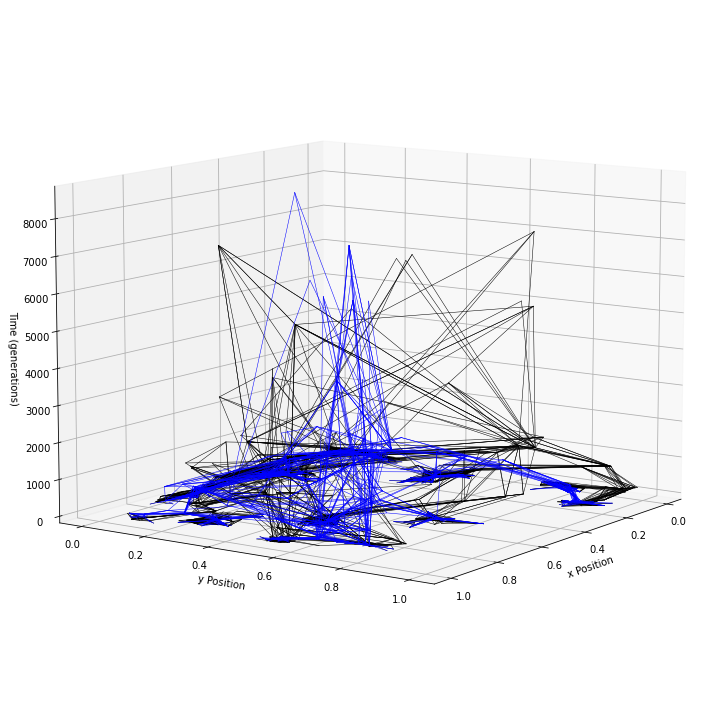

In [66]:
# Let's visualize the tree sequence in three dimensions
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
times = sampled_ts.tables.nodes.time
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = node_locations[edge.child]
        parent_loc = node_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="black", linewidth=0.5)
        
times = slim_inferred_times_marginal
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = slim_inferred_locations[edge.child]
        parent_loc = slim_inferred_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="blue", linewidth=0.5)

ax.set_xlabel("x Position")
ax.set_ylabel("y Position")
ax.set_zlabel("Time (generations)")
ax.view_init(10, 35)
plt.tight_layout()

# Fixing times, inferring location

In [3]:
# ts = tskit.load("slim_2d_continuous_nocompetition_Ne_2000_sigma_0.5_mate_choice_0.5_max_dist_2_generations_8000_ancients_70_rep_2.trees")
ts = tskit.load("slim_2d_continuous_nocompetition_Ne_2000_mu_1e-8_rec_1e-8_sigma_0.5_mate_choice_0.5_max_dist_2_generations_8000_ancients_70_rep_2.trees")
# # The tree sequence needs to be recapitated (so each tree has one root) and mutated (to add mutations)
ts = pyslim.recapitate(ts, recombination_rate=1e-8, ancestral_Ne=500, random_seed=1).simplify()

ts.dump("slim_2d_continuous_nocompetition_N_2000_Ne_1000_mu_1e-8_rec_1e-8_sigma_0.5_mate_choice_0.5_max_dist_2_generations_8000_ancients_70_recapitated_rep_2.trees")
# Now let's randomly sample 200 leaf nodes
rng = np.random.default_rng(20)
random_sample = np.random.choice(np.arange(0, ts.num_samples), 100, replace=False)
# Uncomment line to only sample modern individuals
# random_sample = random_sample[np.where(ts.tables.nodes.time[random_sample] == 0)[0]]
sampled_ts = ts.simplify(samples=random_sample)

In [4]:
# Next, we need to get the locations of the nodes
node_locations = np.full((sampled_ts.num_nodes, 2), -1, dtype=float)
no_location_nodes = []
for node in sampled_ts.nodes():
    if node.individual != -1:
        node_locations[node.id, :] = sampled_ts.individual(node.individual).location[:2]
    else:
        no_location_nodes.append(node.id)
# We want a tensor with only the leaf nodes for inference
leaf_locations = torch.tensor(node_locations[sampled_ts.samples()])




In [ ]:
# Fixing true times
pyro_time, location, migration_scale, unbound_guide, losses, final_elbo = fit_guide(
    sampled_ts, leaf_location=leaf_locations,
    migration_likelihood=models.euclidean_migration, Model=ConditionedTimesNaiveModel,
    Ne=1000, mutation_rate=1e-8, steps=5000, log_every=1000)


step 0 loss = 48.916, Migration scale = 0.9950147867202759, conv. diagnostic = 0.00452, iter. per sec. = 0.00
step 1000 loss = 32.87, Migration scale = 0.28866177797317505, conv. diagnostic = 2.14, iter. per sec. = 51.92


In [ ]:
heuristic_location = tspyro.ops.get_ancestral_geography(sampled_ts, leaf_locations)
is_internal = ~(sampled_ts.tables.nodes.flags == 1)
tspyro_location = location[is_internal]

Text(0, 0.5, 'RMSE')

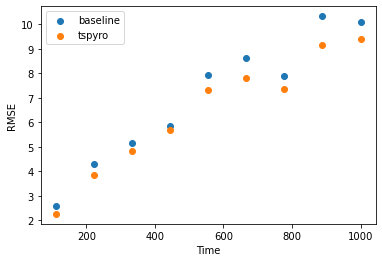

In [93]:
baselines = []
pyro_locs = []
times = np.linspace(1, 1000, 10)
cur_time = 1
for index, i in enumerate(times[1:]):
    in_bound = np.logical_and(sampled_ts.tables.nodes.time[is_internal] > cur_time, sampled_ts.tables.nodes.time[is_internal] < times[index + 1])
    comparable = np.logical_and(np.all(node_locations[is_internal] !=-1, axis=1), in_bound)
    baselines.append(np.sqrt(mean_squared_error(node_locations[is_internal][comparable], heuristic_location[comparable])))
    pyro_locs.append(np.sqrt(mean_squared_error(node_locations[is_internal][comparable], tspyro_location[comparable])))
    cur_time = times[index + 1] 
plt.scatter(times[1:], baselines, label="baseline")
plt.scatter(times[1:], pyro_locs, label="tspyro")
plt.legend()
plt.xlabel("Time")
plt.ylabel("RMSE")


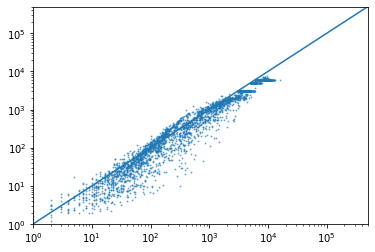

In [346]:
plt.scatter(sampled_ts.tables.nodes.time, pyro_time, s=1, alpha=0.5)
plt.xlim(1, 5e5)
plt.ylim(1, 5e5)
plt.yscale("log")
plt.xscale("log")
plt.plot(plt.xlim(), plt.ylim())

In [95]:
# Inferring the tree sequence
import tsinfer
import json
def convert_to_json_metadata(ts):
    # make a new ts with json metadata
    new_tables = ts.dump_tables()
    # iterate through (nearly) all the tables
    for table_name, table in new_tables.name_map.items():
        # provenance table doesn't have metadata
        if table_name not in ["provenances"]:
            metadata = []
            for row in table:
                try:
                    row_metadata = row.metadata or {}
                    metadata.append(json.dumps(row_metadata).encode())
                except TypeError:
                    raise TypeError(f"Can't convert {row.metadata} to JSON")
            # packset_metadata doesn't validate, so dump json in here and switch schema after
            table.packset_metadata(metadata)
            table.metadata_schema = tskit.MetadataSchema({'codec': 'json'})
    # May also need to convert top level metadata?
    return new_tables.tree_sequence()

def add_times(ts, times):
    tables = ts.dump_tables()
    # tables.time_units = time_units
    constrained_times = tsdate.core.constrain_ages_topo(ts, times, eps=1e-1)
    tables.nodes.time = constrained_times
    tables.mutations.time = np.full(ts.num_mutations, tskit.UNKNOWN_TIME)
    tables.sort()
    return tables.tree_sequence()

tables = convert_to_json_metadata(sampled_ts).dump_tables()
tables.individuals.clear()
inds = np.full(sampled_ts.num_nodes, -1).astype('int32')
# inds[mutated_ts.samples()] = mutated_ts.tables.nodes.individual[mutated_ts.samples()]
# mutated_ts.tables.nodes.individual = inds
# for i in np.unique(mutated_ts.tables.nodes.individual[mutated_ts.samples()]):
#     print(i)
#     tables.individuals.add_row()
tables.nodes.individual = inds
new_ts = tables.tree_sequence()
sampledata = tsinfer.formats.SampleData.from_tree_sequence(
        new_ts, use_sites_time=False, use_individuals_time=True)
sampledata_copy = sampledata.subset(individuals=np.arange(0, sampledata.num_individuals))
unified = tsinfer.infer(sampledata_copy)
times = np.zeros(unified.num_nodes)
times[sampled_ts.samples()] = sampled_ts.tables.nodes.time[sampled_ts.samples()]
unified_times = add_times(unified, times).simplify()
# tables = unified_times.dump_tables()
# pop = tables.nodes.population
# tables.populations.add_row()
# pop[pop==-1] = 6
# tables.nodes.population = pop
# unified_times_pops = tables.tree_sequence().simplify()

/Users/awohns/miniconda3/lib/python3.8/site-packages/tskit/tables.py:2992: FutureWarning: name_map is deprecated; use table_name_map instead
  warnings.warn(


In [96]:
# FROM THIS POINT ON IS TODO: need to make ConditionedTimesModel compatible with tsdate times
# Fixing tsdate times
import models
import pyro
from models import NaiveModel
class ConditionedTimesModel(NaiveModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        ts = kwargs["ts"]
        dated = tsdate.date(ts, Ne=1000, mutation_rate=1e-8)
        self.internal_times = torch.as_tensor(dated.tables.nodes.time[ts.num_samples:],
                                              dtype=torch.get_default_dtype())
    def forward(self, *args, **kwargs):
        with pyro.condition(data={"internal_time": self.internal_times,}):
            return super().forward(*args, **kwargs)

from fit import fit_guide
pyro_time, location, migration_scale, unbound_guide, losses, final_elbo = fit_guide(
    unified_times, leaf_location=leaf_locations,
    migration_likelihood=models.euclidean_migration, Model=ConditionedTimesModel,
    Ne=1000, mutation_rate=1e-8, steps=5000, log_every=1000)





Assign Prior to Each Node: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1584/1584 [00:00<00:00, 2334.56it/s]


UnboundLocalError: local variable 'key_name' referenced before assignment

In [365]:
est = tspyro.ops.get_ancestral_geography(unified_times, leaf_locations)

In [381]:
node_mut = []
for site in sampled_ts.sites():
    if len(site.mutations) == 1:
        node_mut.append(site.mutations[0].node)
inferred_node_mut = []
for site in unified_times.sites():
    if len(site.mutations) == 1:
        inferred_node_mut.append(site.mutations[0].node)

In [382]:
(mean_squared_error(node_locations[node_mut],
                   est[inferred_node_mut]),
 mean_squared_error(node_locations[node_mut],
                   location[inferred_node_mut]))

(34.15738865185529, 29.61010594762554)

In [217]:
modern_only = ts_nomig.simplify(np.where(ts_nomig.tables.nodes.time[ts_nomig.samples()] == 0)[0])
dated_modern = tsdate.date(modern_only, Ne=10000, mutation_rate=1.29e-08, progress=True)
dated = tsdate.date(ts_nomig, mutation_rate=1.29e-08, Ne=10000)

TipCount:   0%|                                                                                                                                                                                                         | 0/3 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [107]:
np.where(np.logical_and(modern_dated < 100, true_times > 1000))

(array([1029, 1033, 3561, 3570, 3573, 3576]),)

In [110]:
modern_dated[1029], true_times[1029]

(17.867307166329724, 4468.0)

In [122]:
np.where(np.cumsum(overlap_ancient) == 1029)

(array([1150]),)

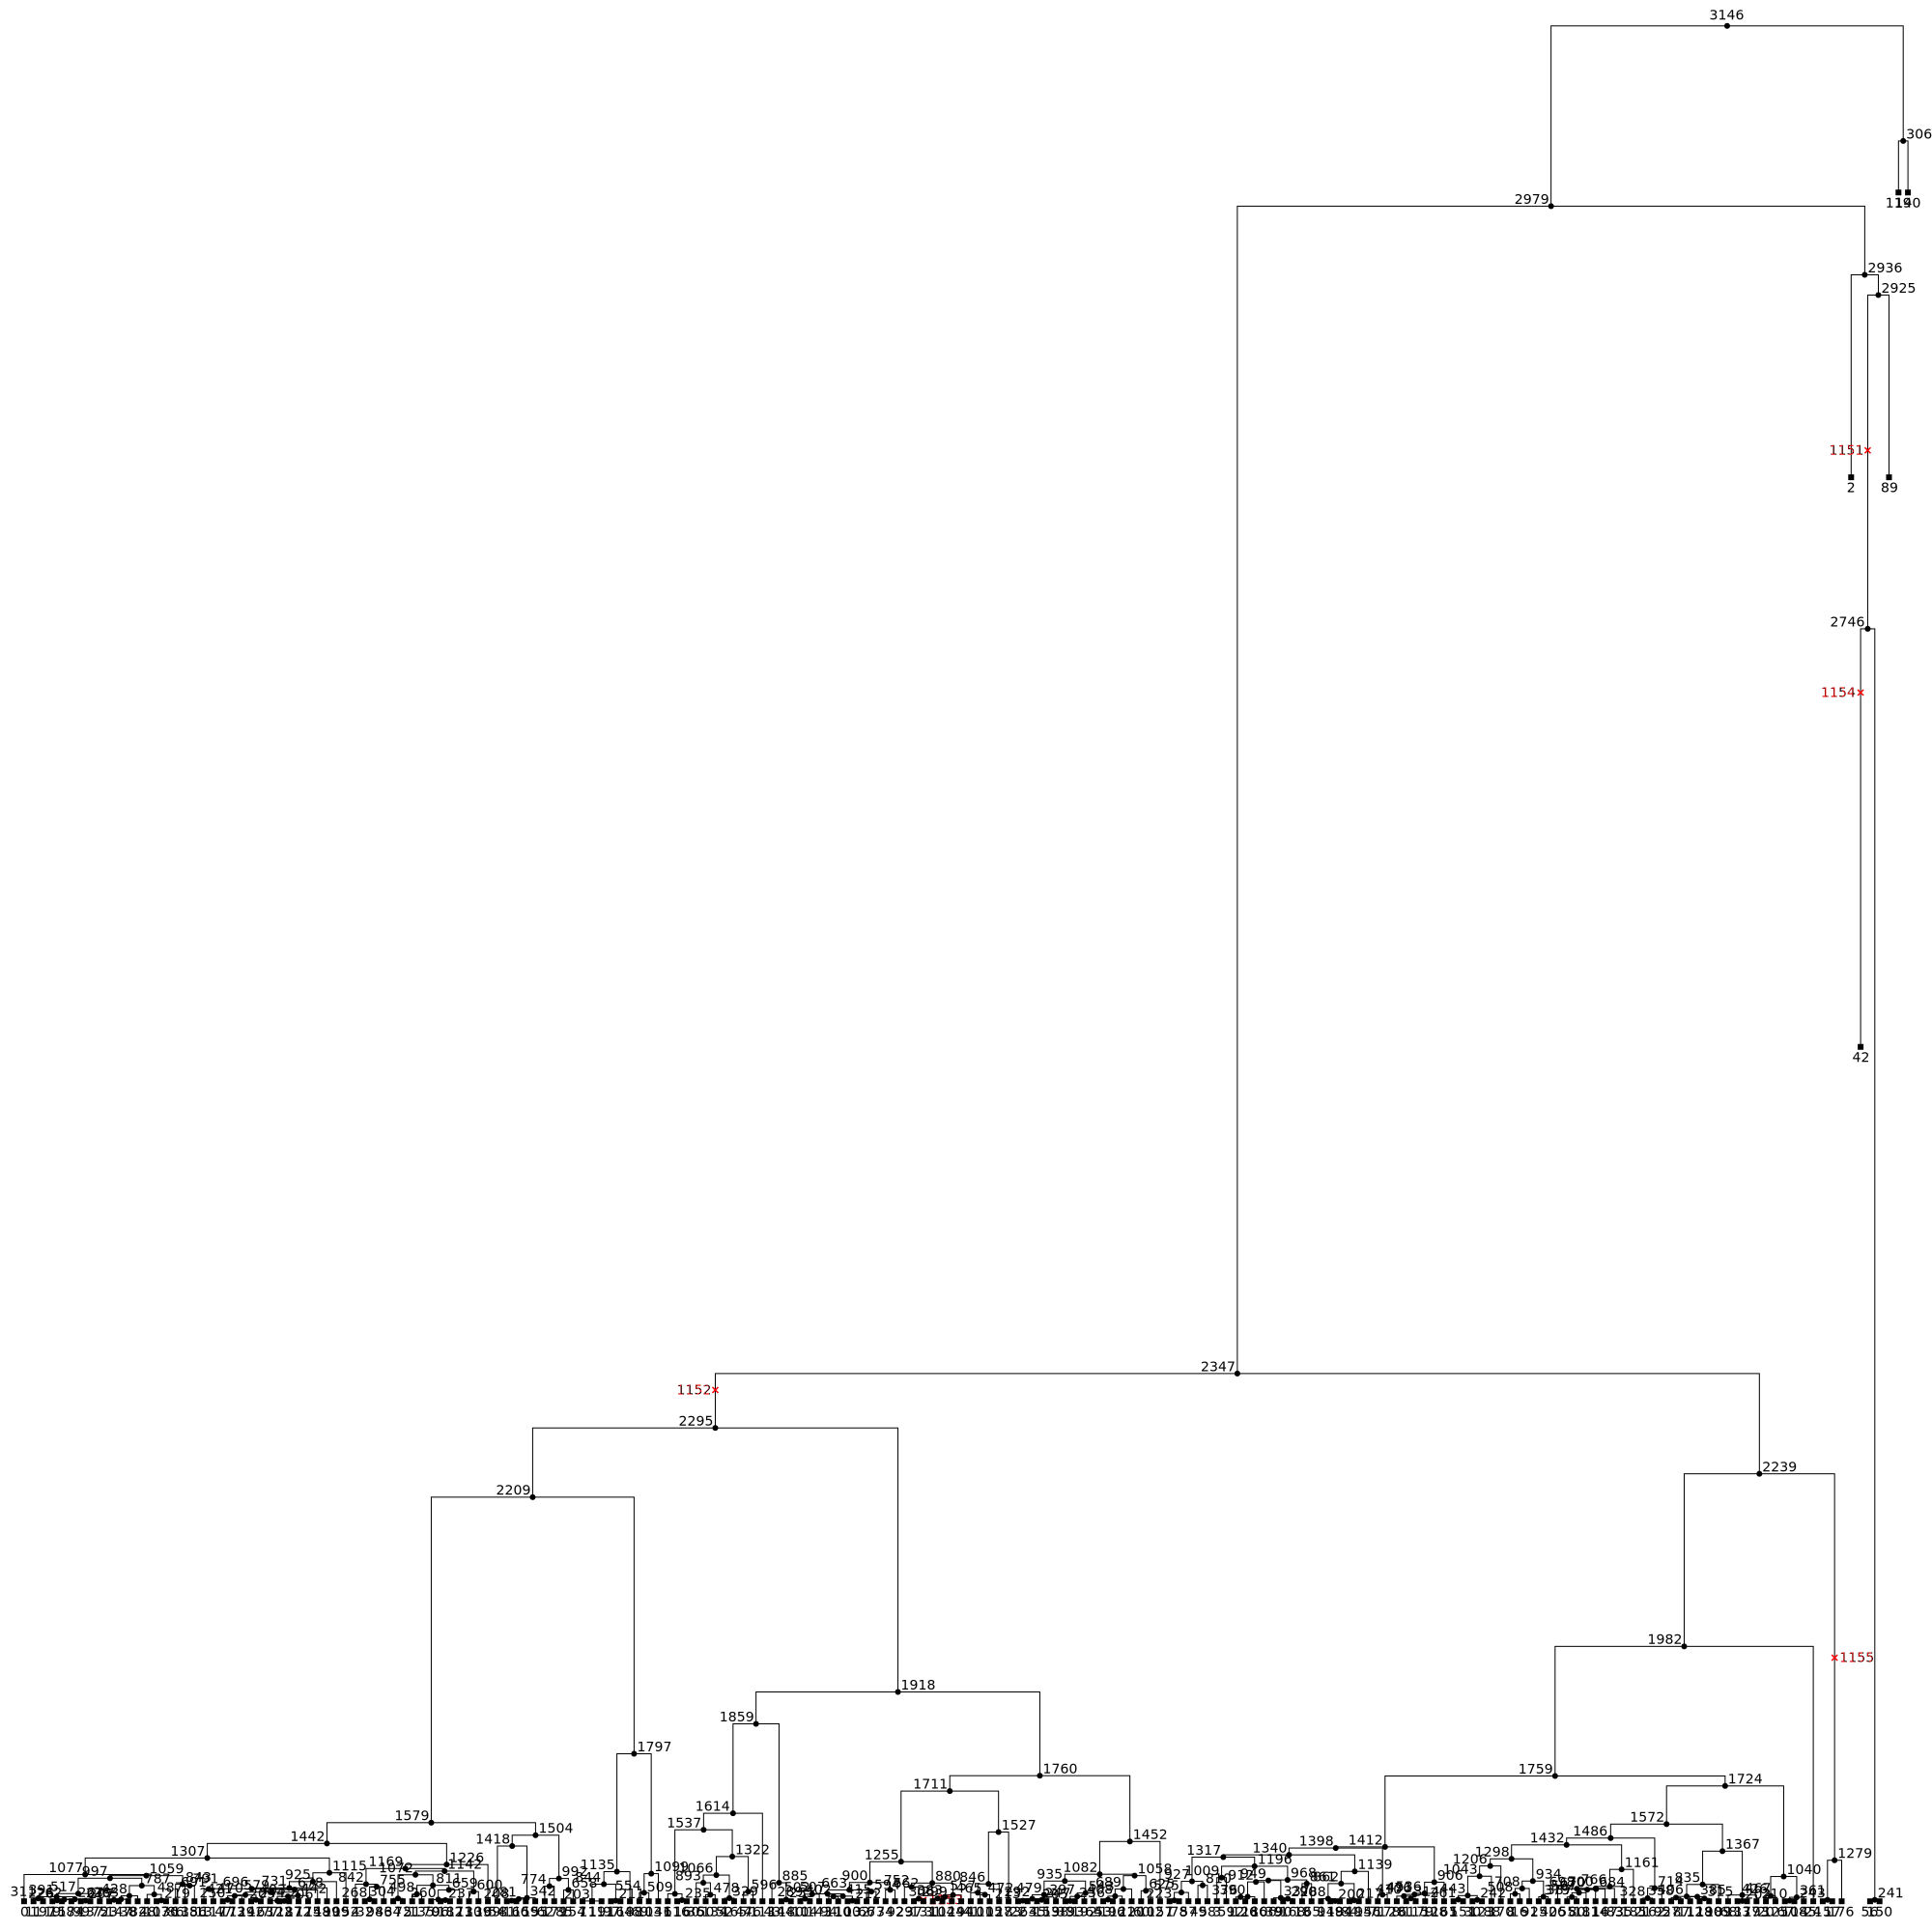

In [130]:
from IPython.display import SVG, display
SVG(sampled_ts.at(3216928.92704452).draw(width=2000, height=2000))

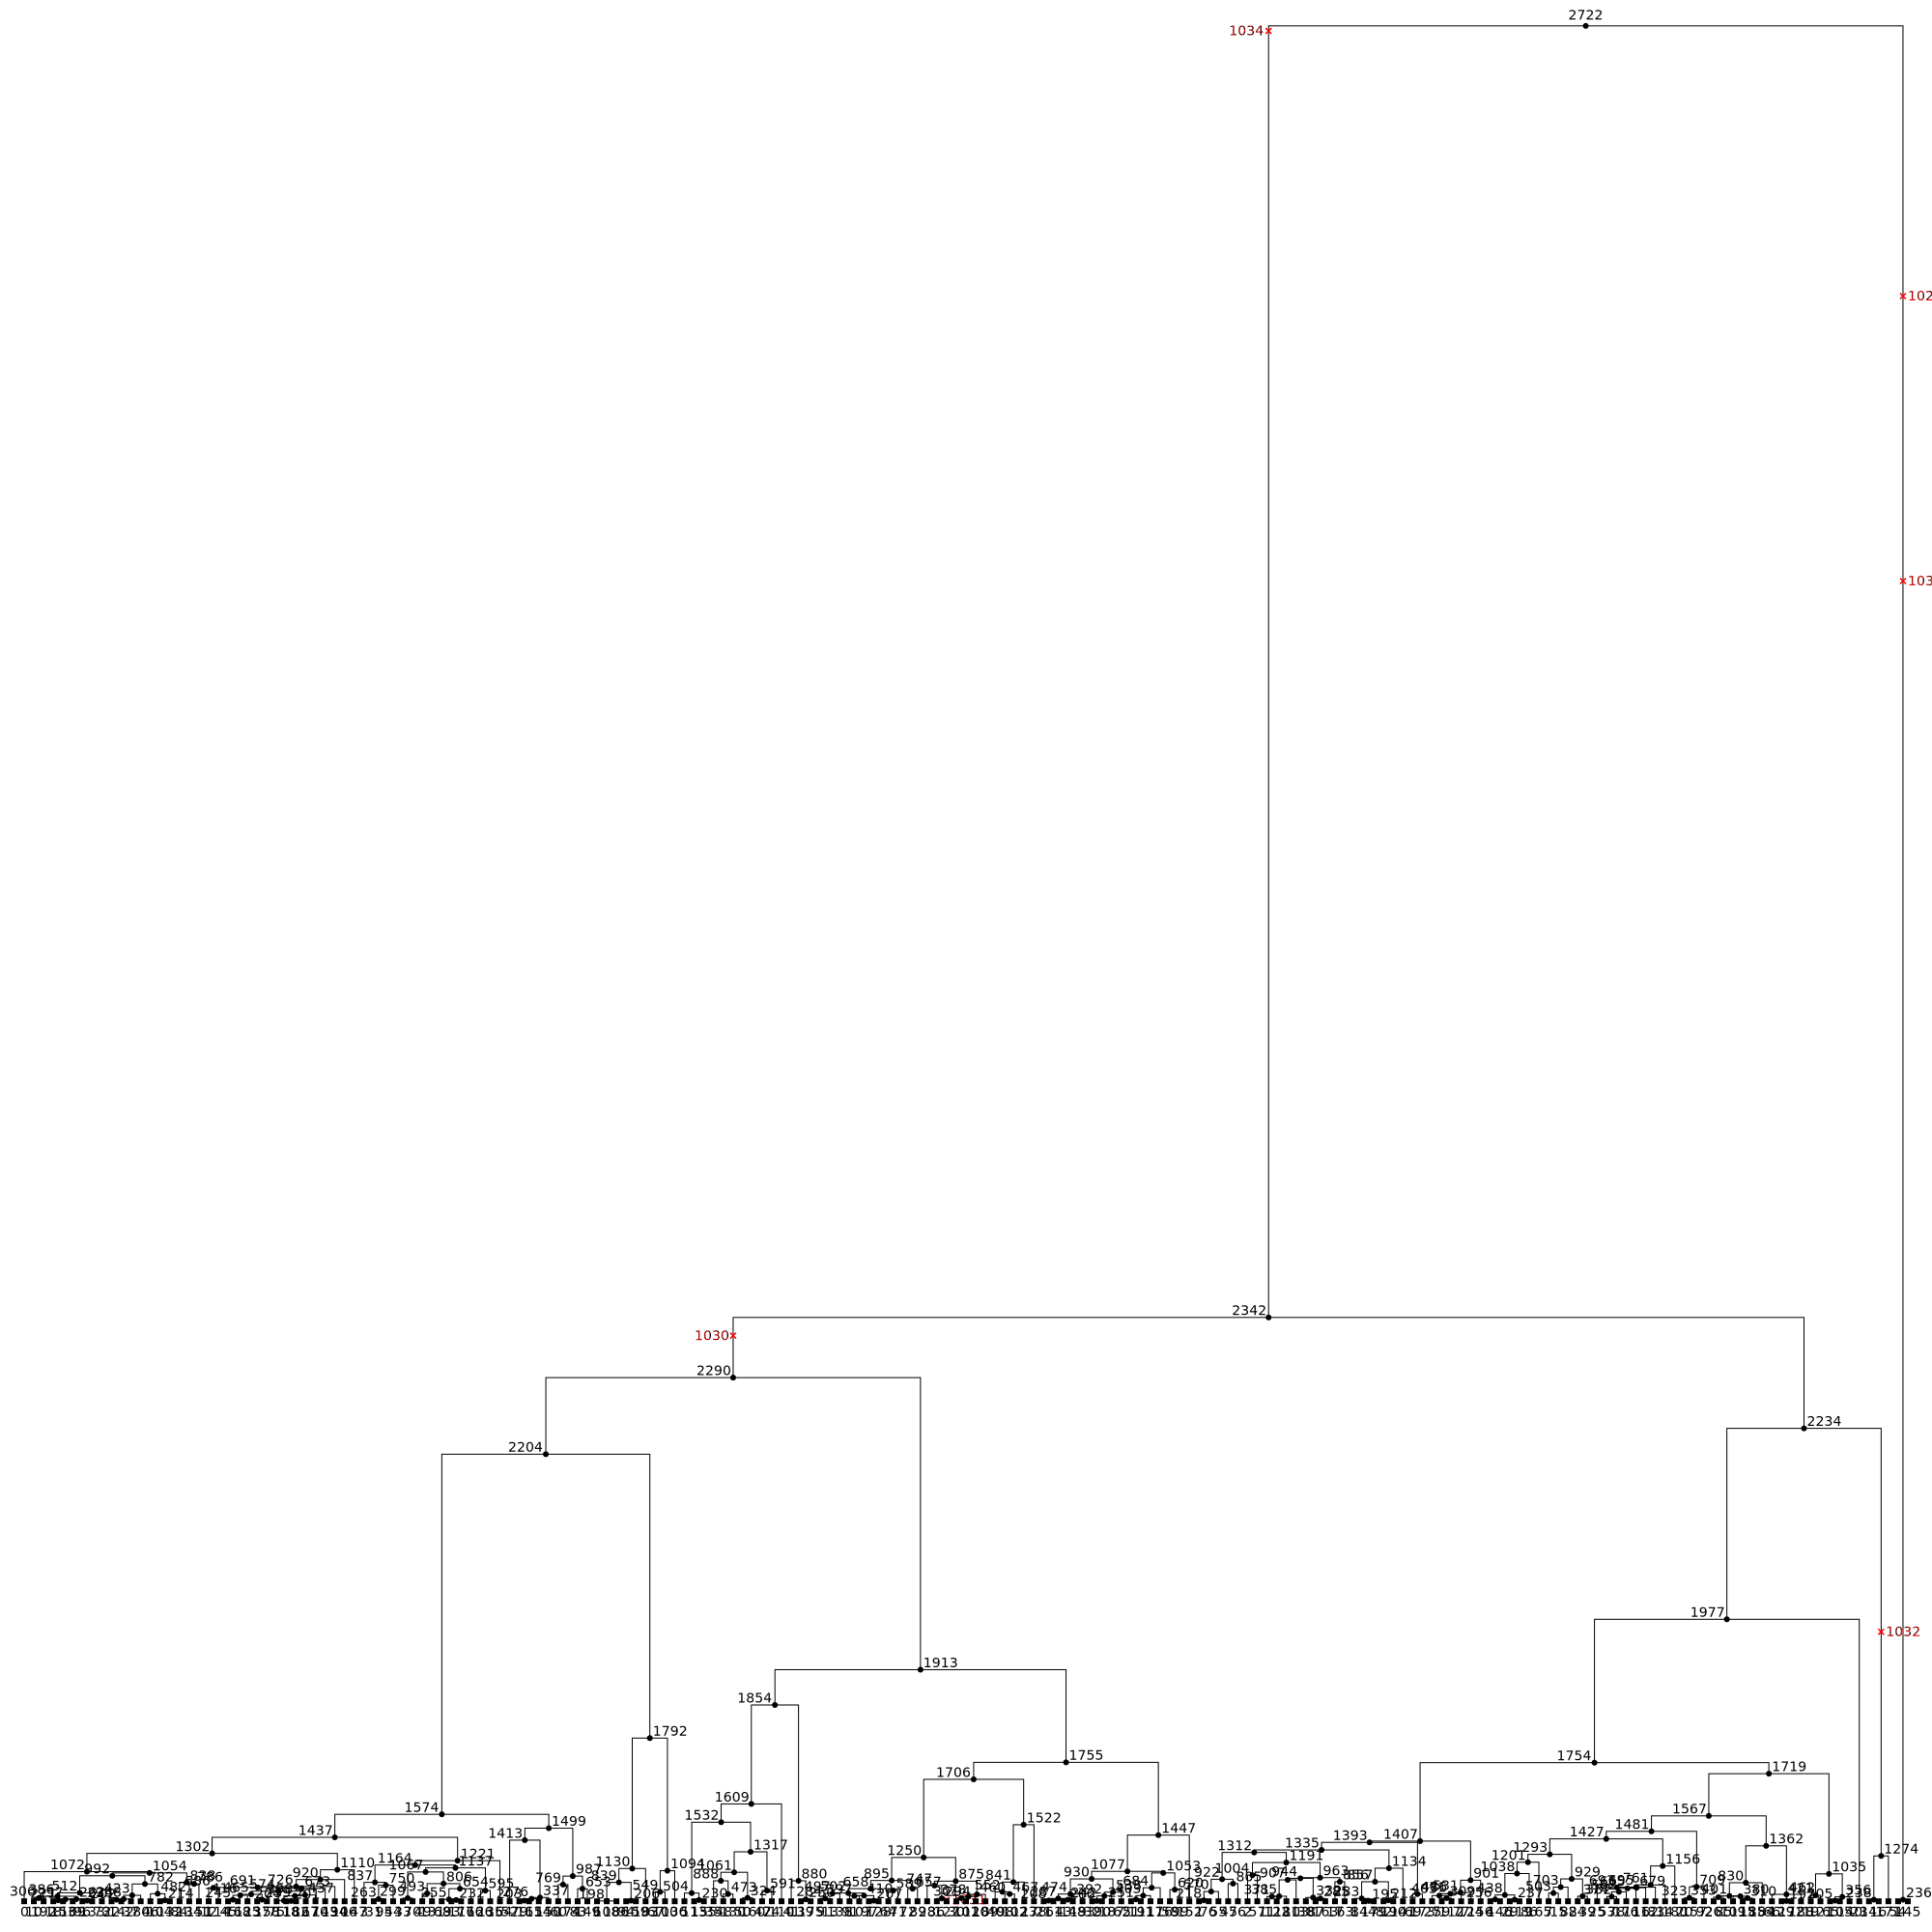

In [131]:
from IPython.display import SVG, display
SVG(modern_only.at(3216928.92704452).draw(width=2000, height=2000))

In [204]:
overlap = np.isin(modern_only.tables.sites.position, dated.tables.sites.position)
overlap_ancient = np.isin(dated.tables.sites.position, modern_only.tables.sites.position)

true_times = tsdate.sites_time_from_ts(ts_nomig, unconstrained=False, node_selection="arithmetic")[overlap_ancient]
ancient_dated = tsdate.sites_time_from_ts(dated, node_selection="arithmetic")[overlap_ancient]
modern_dated = tsdate.sites_time_from_ts(dated_modern, node_selection="arithmetic")[overlap]


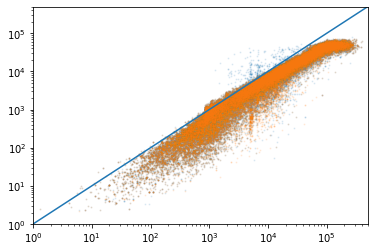

In [206]:
plt.scatter(true_times, modern_dated, s=1, alpha=0.1)
plt.scatter(true_times, ancient_dated, s=1, alpha=0.1)
plt.xlim(1, 5e5)
plt.ylim(1, 5e5)
plt.yscale("log")
plt.xscale("log")
plt.plot(plt.xlim(), plt.ylim())

In [205]:
mean_squared_log_error(true_times, modern_dated), mean_squared_log_error(true_times, ancient_dated)

(0.808198663426073, 0.8663123691768795)

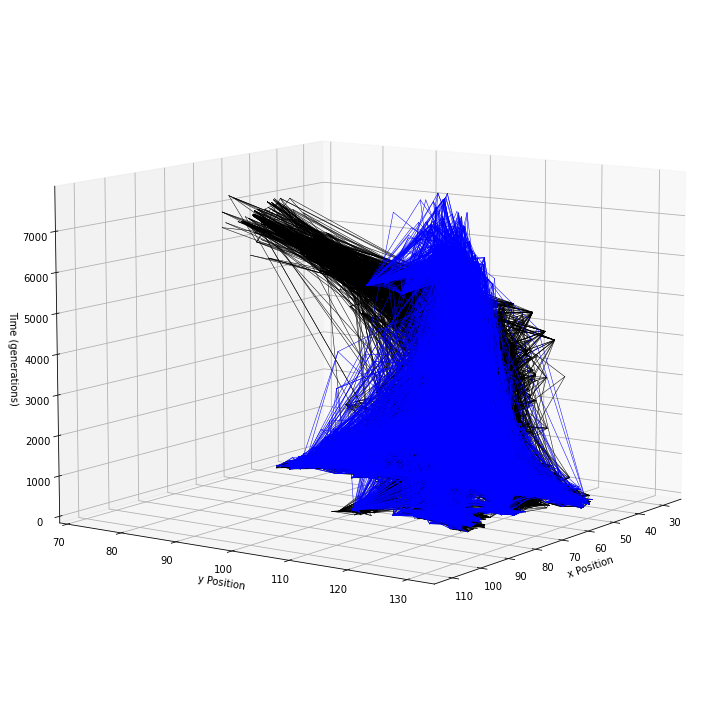

In [54]:
# Let's visualize the tree sequence in three dimensions
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
times = sampled_ts.tables.nodes.time
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = node_locations[edge.child]
        parent_loc = node_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="black", linewidth=0.5)
        
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = location[edge.child]
        parent_loc = location[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="blue", linewidth=0.5)

ax.set_xlabel("x Position")
ax.set_ylabel("y Position")
ax.set_zlabel("Time (generations)")
ax.view_init(10, 35)
plt.tight_layout()

# End to end pipeline